In [1]:
## Created by Wentinn Liao

# CS180 Project 3

In [2]:
!pip install -U setuptools numpy imageio scikit-learn scikit-image torch pytorch-ignite opencv-python matplotlib tensorflow pyvirtualdisplay
!apt install xvfb -y

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
xvfb is already the newest version (2:21.1.4-2ubuntu1.7~22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 18 not upgraded.


In [3]:
#@title Mount Google Drive
import os
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [4]:
#@title Symlink Setup
def ptpp(PATH: str) -> str: # Converts path to python path
    return PATH.replace('\\', '')

DRIVE_PATH = '/content/gdrive/My\ Drive/CS180/HW3'
if not os.path.exists(ptpp(DRIVE_PATH)):
    %mkdir $DRIVE_PATH
SYM_PATH = '/content/HW3'
if not os.path.exists(ptpp(SYM_PATH)):
    !ln -s $DRIVE_PATH $SYM_PATH
%cd $SYM_PATH

/content/gdrive/My Drive/CS180/HW3


In [5]:
import sys
sys.path.append(ptpp(SYM_PATH) + '/code')

In [6]:
#@title Configure Jupyter Notebook
%load_ext autoreload
%autoreload 2

In [7]:
#@title Library Setup
import io
import base64
import math
import numpy as np
import scipy as sc
import skimage as sk
import skimage.io as skio
import skimage.transform as sktr
import cv2
import random
import torch
import tensorflow as tf
import json
from typing import *
from matplotlib import pyplot as plt
from IPython.display import HTML
from IPython import display as ipythondisplay

seed = 7
torch.manual_seed(seed)
random.seed(seed)
torch.set_default_dtype(torch.double)

# Implementation

In [8]:
#@title Utilities
def read_image(imname: str) -> np.ndarray:
    # read in the image
    im = skio.imread(imname)

    # convert to double (might want to do this later on to save memory)
    im = sk.util.img_as_float(im)
    return im

def im_to_uint8(im: np.ndarray) -> np.ndarray:
    return np.floor(256 * im).astype('u1')

def im_rescale(im):
    lo = np.min(im)
    hi = np.max(im)
    return (im - lo) / (hi - lo)

def im_saturate(im):
    return np.stack([im_rescale(im[:, :, c]) for c in range(im.shape[2])], axis=2)

def multiply_outer(v: np.ndarray, arr: np.ndarray, axis=None):
    if axis is None:
        axis = v.ndim
    arr_ = arr.transpose(*range(axis, arr.ndim), *range(axis))
    return (arr_ * v).transpose(*range(arr.ndim - axis, arr.ndim), *range(arr.ndim - axis))

def show_video(video_name: str):
    if os.path.exists(video_name):
        video = io.open(video_name, 'r+b').read()
        encoded = base64.b64encode(video)
        ipythondisplay.display(HTML(data='''<video alt="test" autoplay
                    loop controls style="height: 400px;">
                    <source src="data:video/mp4;base64,{0}" type="video/mp4" />
                </video>'''.format(encoded.decode('ascii'))))
    else:
        print("Could not find video")

In [9]:
import time

class Timer(object):
    start_t: float = 0
    end_t: float = 0

    @classmethod
    def start(cls):
        Timer.start_t = time.perf_counter()

    @classmethod
    def stop(cls):
        Timer.end_t = time.perf_counter()
        return Timer.end_t - Timer.start_t

# Part 1. Defining Correspondences

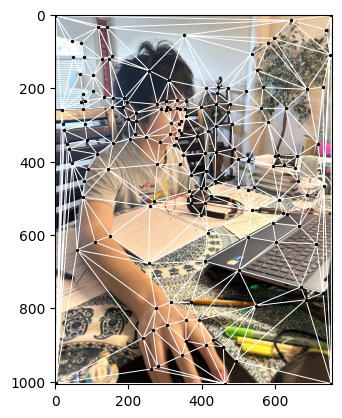

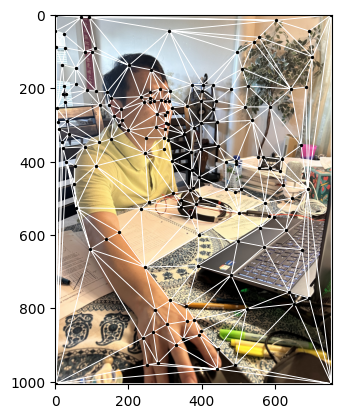

In [10]:
rescale_factor = 0.25

im1 = sk.transform.rescale(read_image('code/data/wenlun.jpg'), rescale_factor, channel_axis=-1)
im2 = sk.transform.rescale(read_image('code/data/dad.jpg'), rescale_factor, channel_axis=-1)

correspondences = json.load(open('code/data/wenlun_dad.json', 'r'))
im1points = np.round(np.array(correspondences['im1Points'])[:, ::-1] * rescale_factor).astype(int)
im2points = np.round(np.array(correspondences['im2Points'])[:, ::-1] * rescale_factor).astype(int)

avgpoints = (im1points + im2points) / 2
triangulation = sc.spatial.Delaunay(avgpoints)

plt.imshow(im1)
plt.triplot(im1points[:, 1], im1points[:, 0], triangulation.simplices, linewidth=0.7, color='white')
plt.scatter(im1points[:, 1], im1points[:, 0], s=2, color='black')
plt.gca().set_aspect('equal')
plt.show()

plt.imshow(im2)
plt.triplot(im2points[:, 1], im2points[:, 0], triangulation.simplices, linewidth=0.7, color='white')
plt.scatter(im2points[:, 1], im2points[:, 0], s=2, color='black')
plt.gca().set_aspect('equal')
plt.show()

# Part 2. Computing the "Mid-way Face"

In [11]:
#@title Morph sequence functions implemented in batch for computational efficiency
def sample_bilinear(im: np.ndarray, points: np.ndarray) -> np.ndarray:
    x, y = points.transpose(-1, *range(points.ndim - 1))
    fx, fy = np.floor(x).astype(int), np.floor(y).astype(int)
    cx, cy = fx + 1, fy + 1

    p, _p, q, _q = cx - x, x - fx, cy - y, y - fy
    cx, cy = np.clip(cx, 0, im.shape[0] - 1), np.clip(cy, 0, im.shape[1] - 1)
    return multiply_outer(p * q, im[fx, fy]) + multiply_outer(_p * q, im[cx, fy]) + multiply_outer(p * _q, im[fx, cy]) + multiply_outer(_p * _q, im[cx, cy])


def computeBackwardAffineFromBatch(tri1: np.ndarray, tris: np.ndarray) -> np.ndarray:
    N = tris.shape[0]
    augmented_tris = np.concatenate([tris.transpose((0, 2, 1)), np.ones((N, 1, 3))], axis=1)
    return np.concatenate([tri1.T @ np.linalg.inv(augmented_tris), np.array([[[0., 0., 1.]]]).repeat(N, axis=0)], axis=1)


def warpToBatch(
    im1: np.ndarray,
    im1points: np.ndarray,
    warp_points: np.ndarray,
    simplices: np.ndarray
) -> np.ndarray:
    N = warp_points.shape[0]
    result = np.ones((N, *im1.shape))

    i = 0
    for simplex in simplices:
        tri1 = im1points[simplex]
        tris = warp_points[:, simplex]

        augmented_points = tf.keras.utils.pad_sequences(
            [np.stack((*(p := np.where(sk.draw.polygon2mask(im1.shape[:2], tri))), np.ones_like(p[0])), axis=1) for tri in tris], padding='post'
        ).transpose(0, 2, 1)

        augmented_backward_points = computeBackwardAffineFromBatch(tri1, tris) @ augmented_points
        backward_points = augmented_backward_points[:, :2].transpose(0, 2, 1)

        rr = augmented_points[:, 0].flatten()
        cc = augmented_points[:, 1].flatten()
        n = np.arange(N).repeat(augmented_points.shape[-1])

        result[n, rr, cc] = sample_bilinear(im1, backward_points).reshape(len(n), im1.shape[-1])

        print(f'Simplex {i} of {len(simplices)} done')
        i += 1
    return result


def morph_images(
    im1: np.ndarray,
    im2: np.ndarray,
    im1points: np.ndarray,
    im2points: np.ndarray,
    warp_frac: np.ndarray,
    dissolve_frac: np.ndarray
) -> np.ndarray:
    warp_points = im1points + np.multiply.outer(warp_frac, im2points - im1points)
    avgpoints = (im1points + im2points) / 2
    triangulation = sc.spatial.Delaunay(avgpoints)

    im1warp = warpToBatch(im1, im1points, warp_points, triangulation.simplices)
    im2warp = warpToBatch(im2, im2points, warp_points, triangulation.simplices)

    return im1warp + multiply_outer(dissolve_frac, im2warp - im1warp)


def midway_image(im1: np.ndarray, im2: np.ndarray, im1points: np.ndarray, im2points: np.ndarray):
    return morph_images(im1, im2, im1points, im2points, np.array([0.5]), np.array([0.5]))[0]

Simplex 0 of 330 done
Simplex 1 of 330 done
Simplex 2 of 330 done
Simplex 3 of 330 done
Simplex 4 of 330 done
Simplex 5 of 330 done
Simplex 6 of 330 done
Simplex 7 of 330 done
Simplex 8 of 330 done
Simplex 9 of 330 done
Simplex 10 of 330 done
Simplex 11 of 330 done
Simplex 12 of 330 done
Simplex 13 of 330 done
Simplex 14 of 330 done
Simplex 15 of 330 done
Simplex 16 of 330 done
Simplex 17 of 330 done
Simplex 18 of 330 done
Simplex 19 of 330 done
Simplex 20 of 330 done
Simplex 21 of 330 done
Simplex 22 of 330 done
Simplex 23 of 330 done
Simplex 24 of 330 done
Simplex 25 of 330 done
Simplex 26 of 330 done
Simplex 27 of 330 done
Simplex 28 of 330 done
Simplex 29 of 330 done
Simplex 30 of 330 done
Simplex 31 of 330 done
Simplex 32 of 330 done
Simplex 33 of 330 done
Simplex 34 of 330 done
Simplex 35 of 330 done
Simplex 36 of 330 done
Simplex 37 of 330 done
Simplex 38 of 330 done
Simplex 39 of 330 done
Simplex 40 of 330 done
Simplex 41 of 330 done
Simplex 42 of 330 done
Simplex 43 of 330 don

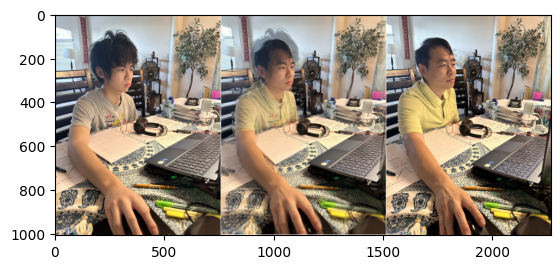

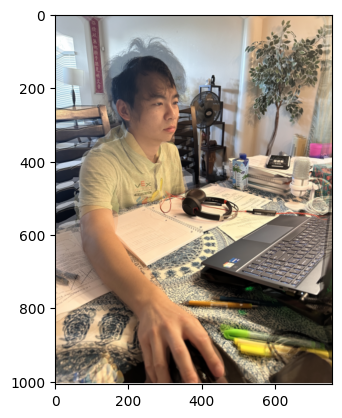

In [12]:
#@title Use general morph sequence to compute midway image as well
midway_im = midway_image(im1, im2, im1points, im2points)
plt.imshow(np.concatenate([im1, midway_im, im2], axis=1))
plt.show()

plt.imshow(midway_im)
plt.show()

# Part 3. The Morph Sequence

In [13]:
#@title Compute morph sequence
T = 100
morph_im = morph_images(im1, im2, im1points, im2points, np.linspace(0, 1, T), np.linspace(0, 1, T))

Simplex 0 of 330 done
Simplex 1 of 330 done
Simplex 2 of 330 done
Simplex 3 of 330 done
Simplex 4 of 330 done
Simplex 5 of 330 done
Simplex 6 of 330 done
Simplex 7 of 330 done
Simplex 8 of 330 done
Simplex 9 of 330 done
Simplex 10 of 330 done
Simplex 11 of 330 done
Simplex 12 of 330 done
Simplex 13 of 330 done
Simplex 14 of 330 done
Simplex 15 of 330 done
Simplex 16 of 330 done
Simplex 17 of 330 done
Simplex 18 of 330 done
Simplex 19 of 330 done
Simplex 20 of 330 done
Simplex 21 of 330 done
Simplex 22 of 330 done
Simplex 23 of 330 done
Simplex 24 of 330 done
Simplex 25 of 330 done
Simplex 26 of 330 done
Simplex 27 of 330 done
Simplex 28 of 330 done
Simplex 29 of 330 done
Simplex 30 of 330 done
Simplex 31 of 330 done
Simplex 32 of 330 done
Simplex 33 of 330 done
Simplex 34 of 330 done
Simplex 35 of 330 done
Simplex 36 of 330 done
Simplex 37 of 330 done
Simplex 38 of 330 done
Simplex 39 of 330 done
Simplex 40 of 330 done
Simplex 41 of 330 done
Simplex 42 of 330 done
Simplex 43 of 330 don

In [14]:
#@title Accumulate image frames into video and save
video_name = 'images/wenlun_dad_morph.mp4'
fps = 25

height, width, _ = im1.shape
video = cv2.VideoWriter('images/wenlun_dad_morph.mp4', cv2.VideoWriter_fourcc(*'mp4v'), fps, (width, height))
for im in morph_im:
    video.write(sk.img_as_ubyte(im[:, :, ::-1]))
for im in reversed(morph_im):
    video.write(sk.img_as_ubyte(im[:, :, ::-1]))
video.release()

In [15]:
#@title Display video with VirtualDisplay
from pyvirtualdisplay import Display

display = Display(visible=0, size=(1400, 900))
display.start()
show_video('images/wenlun_dad_morph.mp4')

Output hidden; open in https://colab.research.google.com to view.

# Part 4. The "Mean face" of a population

In [16]:
#@title Data extraction from Dane .asf files
def augment(arr: np.ndarray, k: int=4):
    return np.vstack([
        np.array(arr),
        np.stack([np.linspace(0, 1 - 1 / k, k), np.zeros(k)], axis=1),
        np.stack([np.ones(k), np.linspace(0, 1 - 1 / k, k)], axis=1),
        np.stack([np.linspace(1, 1 / k, k), np.ones(k)], axis=1),
        np.stack([np.zeros(k), np.linspace(1, 1 / k, k)], axis=1)
    ])

def parse_asf(asf_fname: str, k: int=4):
    fp = open(asf_fname, 'r')
    lines = [l[:-1] for l in fp.readlines() if l[0] != '#' and len(l) != 1]

    arr = []
    for l in lines[1:-1]:
        y, x = l.split()[2:4]
        arr.append([float(x), float(y)])

    return augment(np.array(arr))

In [17]:
#@title Construct dataset
db_name = 'code/data/imm_face_db'
im_prefix_list = list(sorted({fname[:5] for fname in os.listdir(db_name) if fname[2:4] == '-2'}))

dataset = [(
    skio.imread(f'{db_name}/{im_prefix}.jpg'),
    parse_asf(f'{db_name}/{im_prefix}.asf')
) for im_prefix in im_prefix_list]

for im, points in dataset:
    points *= im.shape[:2]

ims = np.stack([im for im, _ in dataset]) / 255
impoints = np.stack([points for _, points in dataset])

In [18]:
#@title Face averaging functions implemented in batch for computational efficiency
def sample_bilinear_batch(ims: np.ndarray, points: np.ndarray) -> np.ndarray:
    N = len(ims)
    n = np.tile(np.arange(N).reshape(N, *(1 for _ in range(points.ndim - 2))), (1, *points.shape[1:-1]))
    x, y = points.transpose(-1, *range(points.ndim - 1))
    fx, fy = np.floor(x).astype(int), np.floor(y).astype(int)
    cx, cy = fx + 1, fy + 1

    p, _p, q, _q = cx - x, x - fx, cy - y, y - fy
    cx, cy = np.clip(cx, 0, ims.shape[1] - 1), np.clip(cy, 0, ims.shape[2] - 1)
    return multiply_outer(p * q, ims[n, fx, fy]) + multiply_outer(_p * q, ims[n, cx, fy]) + multiply_outer(p * _q, ims[n, fx, cy]) + multiply_outer(_p * _q, ims[n, cx, cy])


def computeBackwardAffineToBatch(tris: np.ndarray, tri2: np.ndarray) -> np.ndarray:
    N = tris.shape[0]
    augmented_tri2 = np.concatenate([tri2.T, np.ones((1, 3))])
    return np.concatenate([tris.transpose(0, 2, 1) @ np.linalg.inv(augmented_tri2), np.array([[[0., 0., 1.]]]).repeat(N, axis=0)], axis=1)


def warpFromBatch(
    ims: np.ndarray,
    impoints: np.ndarray,
    im2points: np.ndarray,
    simplices: np.ndarray
) -> np.ndarray:
    N = ims.shape[0]
    result = np.ones_like(ims)

    Timer.start()
    t = 0
    for simplex in simplices:
        tris = impoints[:, simplex]
        tri2 = im2points[simplex]

        augmented_points = np.stack((*(p := np.where(sk.draw.polygon2mask(ims.shape[1:3], tri2))), np.ones_like(p[0])))

        augmented_backward_points = computeBackwardAffineToBatch(tris, tri2) @ augmented_points
        backward_points = augmented_backward_points[:, :2].transpose(0, 2, 1)

        rr, cc, _ = augmented_points
        result[:, rr, cc] = sample_bilinear_batch(ims, backward_points)
    return result


def average_images(
    ims,
    impoints: np.ndarray
) -> Tuple[np.ndarray]:
    avgpoints = np.mean(impoints, axis=0)
    triangulation = sc.spatial.Delaunay(avgpoints)

    imwarps = warpFromBatch(ims, impoints, avgpoints, triangulation.simplices)
    return np.mean(imwarps, axis=0), avgpoints, triangulation

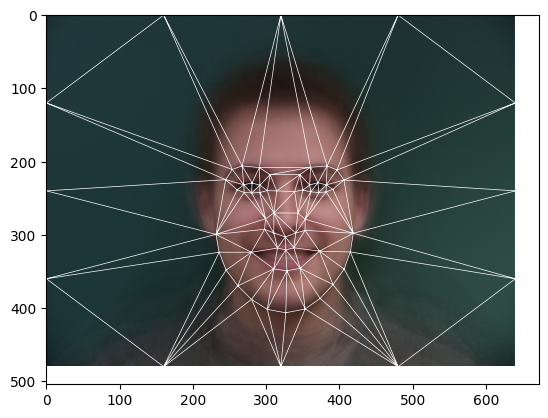

In [19]:
avg_im, avgpoints, triangulation = average_images(ims, impoints)

plt.imshow(avg_im)
plt.triplot(avgpoints[:, 1], avgpoints[:, 0], triangulation.simplices, linewidth=0.5, color='white')
plt.show()

In [36]:
s = 3
indices = np.random.choice(np.arange(len(ims)), s ** 2, replace=False)
sample_ims, sample_points = ims[indices], impoints[indices]
sample_ims[(s ** 2 - 1) // 2] = avg_im
sample_points[(s ** 2 - 1) // 2] = avgpoints

sample_to_mean = warpFromBatch(sample_ims, sample_points, avgpoints, triangulation.simplices)
mean_to_sample = warpToBatch(avg_im, avgpoints, sample_points, triangulation.simplices)

Simplex 0 of 130 done
Simplex 1 of 130 done
Simplex 2 of 130 done
Simplex 3 of 130 done
Simplex 4 of 130 done
Simplex 5 of 130 done
Simplex 6 of 130 done
Simplex 7 of 130 done
Simplex 8 of 130 done
Simplex 9 of 130 done
Simplex 10 of 130 done
Simplex 11 of 130 done
Simplex 12 of 130 done
Simplex 13 of 130 done
Simplex 14 of 130 done
Simplex 15 of 130 done
Simplex 16 of 130 done
Simplex 17 of 130 done
Simplex 18 of 130 done
Simplex 19 of 130 done
Simplex 20 of 130 done
Simplex 21 of 130 done
Simplex 22 of 130 done
Simplex 23 of 130 done
Simplex 24 of 130 done
Simplex 25 of 130 done
Simplex 26 of 130 done
Simplex 27 of 130 done
Simplex 28 of 130 done
Simplex 29 of 130 done
Simplex 30 of 130 done
Simplex 31 of 130 done
Simplex 32 of 130 done
Simplex 33 of 130 done
Simplex 34 of 130 done
Simplex 35 of 130 done
Simplex 36 of 130 done
Simplex 37 of 130 done
Simplex 38 of 130 done
Simplex 39 of 130 done
Simplex 40 of 130 done
Simplex 41 of 130 done
Simplex 42 of 130 done
Simplex 43 of 130 don

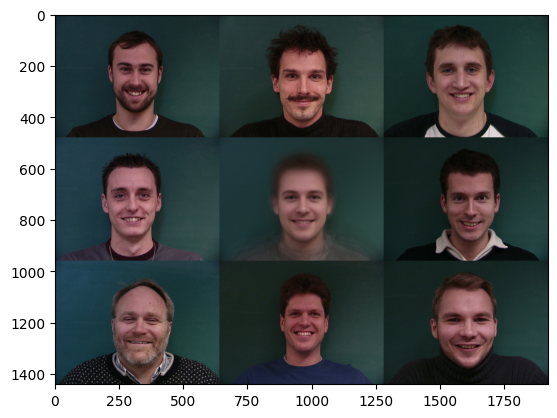

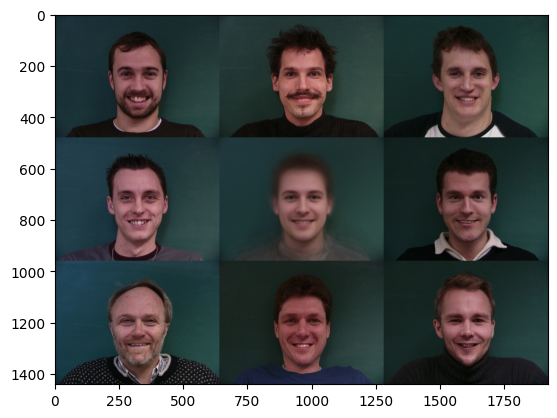

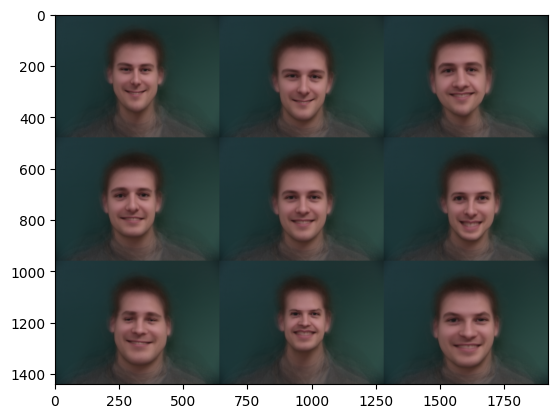

In [37]:
sample_image = np.vstack([
    np.hstack([sample_ims[s * i + j] for j in range(s)]) for i in range(s)
])
skio.imsave('images/Dane samples.jpg', sk.img_as_ubyte(sample_image))
plt.imshow(sample_image)
plt.show()

sample_to_mean_image = np.vstack([
    np.hstack([sample_to_mean[s * i + j] for j in range(s)]) for i in range(s)
])
skio.imsave('images/Dane samples_to_mean.jpg', sk.img_as_ubyte(sample_to_mean_image))
plt.imshow(sample_to_mean_image)
plt.show()

mean_to_sample_image = np.vstack([
    np.hstack([mean_to_sample[s * i + j] for j in range(s)]) for i in range(s)
])
skio.imsave('images/Dane mean_to_samples.jpg', sk.img_as_ubyte(mean_to_sample_image))
plt.imshow(mean_to_sample_image)
plt.show()

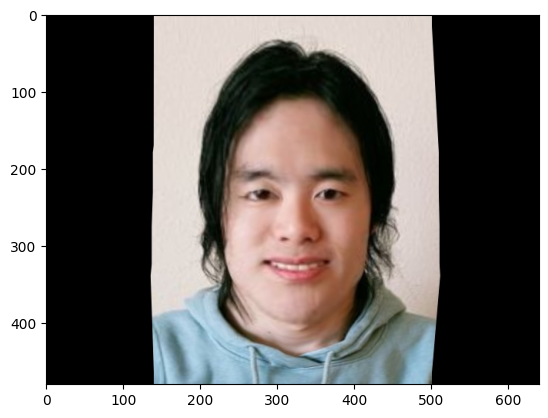

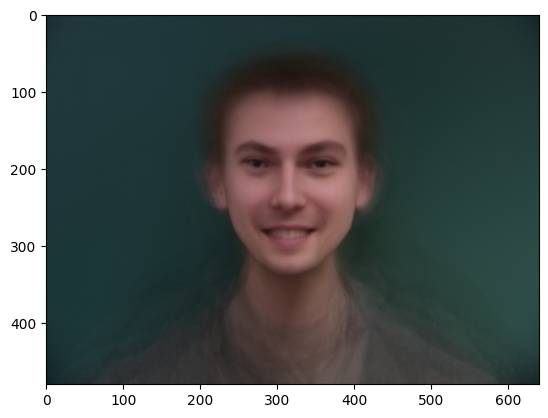

In [38]:
wentinn = read_image('code/data/wentinn.jpg')
wentinn_points = augment(np.array(json.load(open('code/data/face_ordering_wentinn.json', 'r'))['im2Points'])[:, ::-1].astype(float) / avg_im.shape[:2]) * avg_im.shape[:2]

wentinn_to_mean = warpFromBatch(np.array([wentinn]), np.array([wentinn_points]), avgpoints, triangulation.simplices)[0]
mean_to_wentinn = warpFromBatch(np.array([avg_im]), np.array([avgpoints]), wentinn_points, triangulation.simplices)[0]

skio.imsave('images/wentinn_to_mean.jpg', sk.img_as_ubyte(wentinn_to_mean))
plt.imshow(wentinn_to_mean)
plt.show()

skio.imsave('images/mean_to_wentinn.jpg', sk.img_as_ubyte(mean_to_wentinn))
plt.imshow(mean_to_wentinn)
plt.show()

# Part 5. Caricatures: Extrapolating from the mean

In [39]:
s = 3
indices = np.random.choice(np.arange(len(ims)), s ** 2, replace=False)
sample_ims, sample_points = ims[indices], impoints[indices]
sample_ims[(s ** 2 - 1) // 2] = avg_im
sample_points[(s ** 2 - 1) // 2] = avgpoints

In [40]:
def warpBatchToBatch(
    ims: np.ndarray,
    impoints: np.ndarray,
    warp_points: np.ndarray,
    simplices: np.ndarray
) -> np.ndarray:
    N = ims.shape[0]
    result = np.ones_like(ims)

    for simplex in simplices:
        tri1 = impoints[simplex]
        tris = warp_points[:, simplex]

        augmented_points = tf.keras.utils.pad_sequences(
            [np.stack((*(p := np.where(sk.draw.polygon2mask(ims.shape[1:3], tri))), np.ones_like(p[0])), axis=1) for tri in tris], padding='post'
        ).transpose(0, 2, 1)

        augmented_backward_points = computeBackwardAffineFromBatch(tri1, tris) @ augmented_points
        backward_points = augmented_backward_points[:, :2].transpose(0, 2, 1)

        rr = augmented_points[:, 0].flatten()
        cc = augmented_points[:, 1].flatten()
        n = np.arange(N).repeat(augmented_points.shape[-1])

        result[n, rr, cc] = sample_bilinear_batch(ims, backward_points).reshape(len(n), ims.shape[-1])
    return result

def extrapolate_images(
    ims: np.ndarray,
    impoints: np.ndarray,
    anchor_im: np.ndarray,
    anchor_points: np.ndarray,
    simplices: np.ndarray,
    alpha: float
) -> np.ndarray:
    warped_ims = warpFromBatch(ims, impoints, anchor_points, simplices)

    warped_differential_ims = warped_ims - anchor_im
    differential_points = impoints - anchor_points

    warped_extrapolated_ims = anchor_im + warped_differential_ims * alpha
    extrapolated_points = anchor_points + differential_points * alpha

    extrapolated_ims = warpBatchToBatch(warped_extrapolated_ims, anchor_points, extrapolated_points, simplices)
    return np.clip(extrapolated_ims, 0, 1)

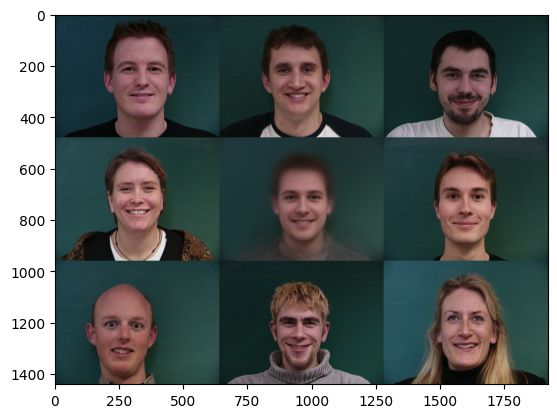

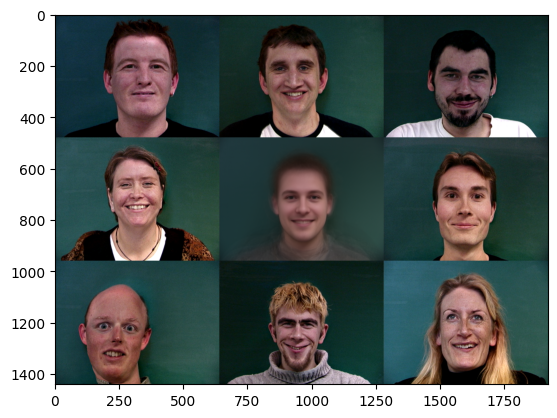

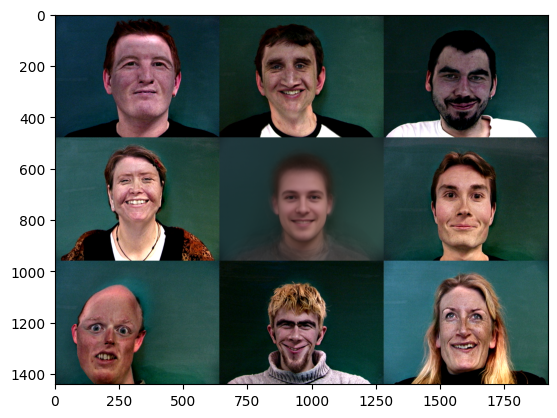

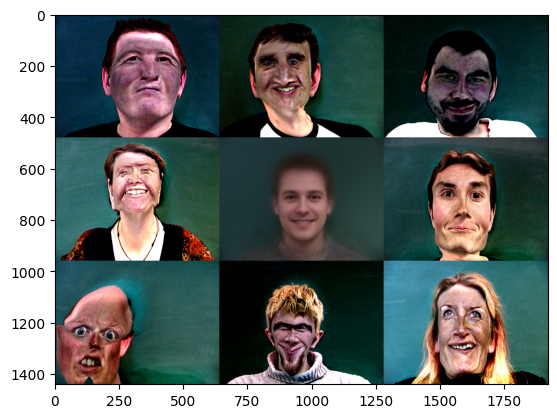

In [42]:
sample_image = np.vstack([
    np.hstack([sample_ims[s * i + j] for j in range(s)]) for i in range(s)
])
skio.imsave('images/Dane samples 2.jpg', sk.img_as_ubyte(sample_image))
plt.imshow(sample_image)
plt.show()

for alpha in [1.5, 2, 3]:
    extrapolated_ims = extrapolate_images(sample_ims, sample_points, avg_im, avgpoints, triangulation.simplices, alpha)
    extrapolated_image = np.vstack([
        np.hstack([extrapolated_ims[s * i + j] for j in range(s)]) for i in range(s)
    ])

    skio.imsave(f'images/Dane extrapolations a={alpha}.jpg', sk.img_as_ubyte(extrapolated_image))
    plt.imshow(extrapolated_image)
    plt.show()

# Bells & Whistles. Caricatures: Extrapolating with a PCA basis

In [76]:
def pca_basis(
    ims: np.ndarray,
    impoints: np.ndarray,
    anchor_im: np.ndarray,
    anchor_points: np.ndarray,
    simplices: np.ndarray
) -> Tuple[np.ndarray]:
    N, H, W, C = ims.shape
    N, D, _ = impoints.shape

    warped_ims = warpFromBatch(ims, impoints, anchor_points, simplices)

    warped_differential_ims = warped_ims - anchor_im
    differential_points = impoints - anchor_points
    differential_points[:, :-16] -= np.tile(np.mean(differential_points, axis=1)[:, None, :], (1, impoints.shape[1] - 16, 1))

    flattened_differential = np.concatenate([
        warped_differential_ims.reshape(N, H * W * C),
        differential_points.reshape(N, D * 2)
    ], axis=1).T

    U, S, Vh = np.linalg.svd(flattened_differential, full_matrices=False)
    assert N == len(S), f'Expected batch size {N} to be less than feature dimension {H * W * C + D * 2}'
    flattened_pca_basis = U * S

    warped_im_basis = flattened_pca_basis[:H * W * C].T.reshape(N, H, W, C)
    point_basis = flattened_pca_basis[H * W * C:].T.reshape(N, D, 2)

    return warped_im_basis, point_basis

In [77]:
warped_im_basis, point_basis = pca_basis(ims, impoints, avg_im, avgpoints, triangulation.simplices)

In [78]:
def extrapolate_basis_images(
    basis_ims: np.ndarray,
    basis_points: np.ndarray,
    anchor_im: np.ndarray,
    anchor_points: np.ndarray,
    simplices: np.ndarray,
    alpha: float
) -> np.ndarray:
    warped_extrapolated_ims = anchor_im + basis_ims * alpha
    extrapolated_points = anchor_points + basis_points * alpha

    extrapolated_ims = warpBatchToBatch(warped_extrapolated_ims, anchor_points, extrapolated_points, simplices)
    return np.clip(extrapolated_ims, 0, 1)

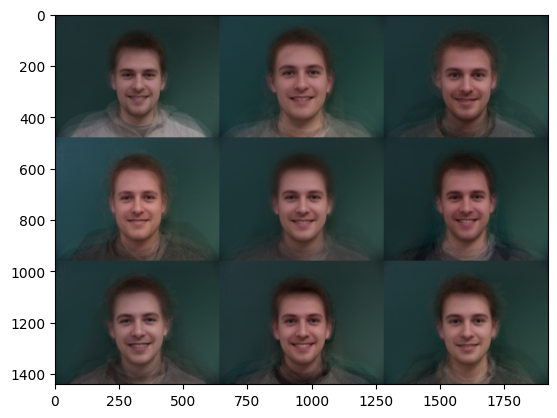

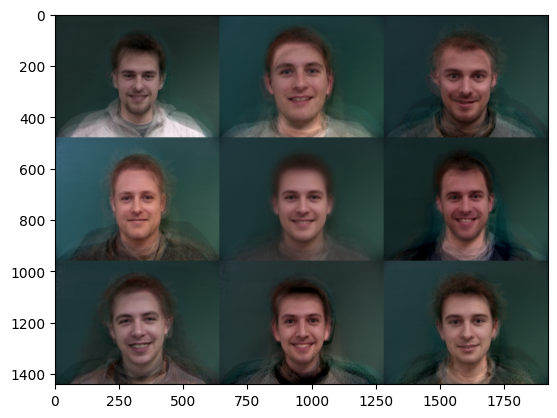

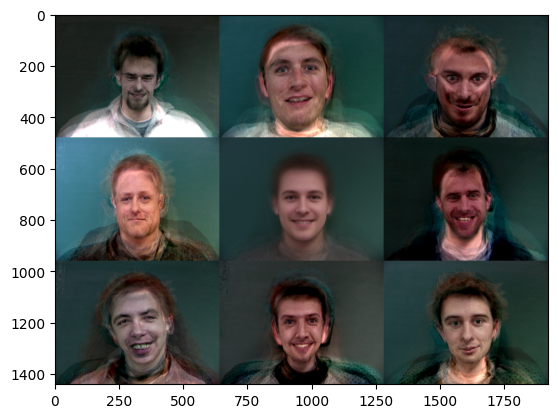

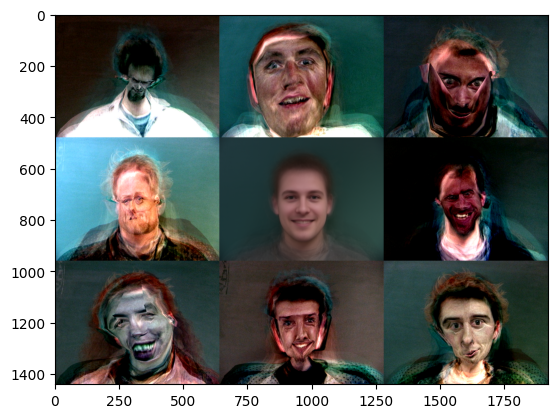

In [79]:
sample_warped_im_basis = np.concatenate([
    warped_im_basis[:4],
    np.zeros((1, *avg_im.shape)),
    warped_im_basis[4:8]
])
sample_point_basis = np.concatenate([
    point_basis[:4],
    np.zeros((1, *avgpoints.shape)),
    point_basis[4:8]
])

for alpha in [0.25, 0.5, 1, 2]:
    extrapolated_basis_ims = extrapolate_basis_images(sample_warped_im_basis, sample_point_basis, avg_im, avgpoints, triangulation.simplices, alpha)
    extrapolated_basis_image = np.vstack([
        np.hstack([extrapolated_basis_ims[s * i + j] for j in range(s)]) for i in range(s)
    ])

    skio.imsave(f'images/Dane basis extrapolations a={alpha}.jpg', sk.img_as_ubyte(extrapolated_basis_image))
    plt.imshow(extrapolated_basis_image)
    plt.show()

In [29]:
#@title Part 1.2: Derivative of Gaussian (DoG) Filter

threshold = 0.1

im = read_image('code/data/cameraman.png')[:, :, 0]

Dx = np.array([[1.], [-1.]])
Dy = np.array([[1., -1.]])
G = (G := cv2.getGaussianKernel(8, 1)) @ G.T

# Separate Convolutions
blurred_im = sc.signal.convolve2d(im, G, mode='same')

Dblurred_im_Dx = sc.signal.convolve2d(blurred_im, Dx, mode='same')
Dblurred_im_Dy = sc.signal.convolve2d(blurred_im, Dy, mode='same')

print('Edges as gradient magnitude of blurred image')
edge_blurred_im = np.linalg.norm(np.stack([Dblurred_im_Dx, Dblurred_im_Dy]), axis=0)
skio.imshow(edge_blurred_im)
skio.show()

print('Binary separate convolutions')
binary_edge_blurred_im = edge_blurred_im > threshold
skio.imshow(binary_edge_blurred_im)
skio.show()

# Single Convolution
DxG = sc.signal.convolve2d(G, Dx, mode='same')
DyG = sc.signal.convolve2d(G, Dy, mode='same')

Dim_DxG = sc.signal.convolve2d(im, DxG, mode='same')
Dim_DyG = sc.signal.convolve2d(im, DyG, mode='same')

print('Edges as DoG of image')
edge_blurred_im2 = np.linalg.norm(np.stack([Dim_DxG, Dim_DyG]), axis=0)
skio.imshow(edge_blurred_im2)
skio.show()

print('Binary single convolutions')
binary_edge_blurred_im2 = edge_blurred_im2 > threshold
skio.imshow(binary_edge_blurred_im2)
skio.show()

FileNotFoundError: ignored

# Part 2: Fun with Frequencies!

In [ ]:
#@title Part 2.1: Image "Sharpening"

sharpening = 1
images = [
    'taj.jpg',
    'genki 1.jpg',
    'hadelich.jpg',
    'benny.jpg'
]

G = (G := cv2.getGaussianKernel(7, 1)) @ G.T
I = (v := np.array([[0., 0., 0., 1., 0., 0., 0.]])).T @ v
S = (I + sharpening * (I - G))[:, :, None]

for image in images:
    print(f'Original {image}')
    im = read_image(f'code/data/{image}')
    skio.imshow(im)
    skio.show()

    print(f'Sharpened {image}')
    sharpened_im = np.clip(sc.signal.convolve(im, S, mode='same'), 0, 1)
    skio.imshow(sharpened_im)
    skio.show()

    skio.imsave(f'images/Sharpened {image}', sk.img_as_ubyte(sharpened_im), quality=100)

In [ ]:
print(f'Original image')
im = read_image(f'code/data/genki 2.jpg')
skio.imshow(im)
skio.show()

print('Blurred and resharpened image')
blurred_im = sc.signal.convolve(im, G[:, :, None], mode='same')
resharpened_im = np.clip(sc.signal.convolve(blurred_im, S, mode='same'), 0, 1)
skio.imshow(resharpened_im)
skio.show()

print((np.linalg.norm(im - resharpened_im) ** 2) / np.prod(im.shape))

## Note: Part 2.2 does not run on Colab because pop-up/interactive windows are disabled

In [ ]:
#@title Part 2.2: Hybrid Images
import hybrid_python.align_image_code as lib

im_pairs = [
    ['code/data/joy.jpg', 'code/data/genki 1.jpg', 18],
    ['code/data/eddy chen.jpg', 'code/data/brett yang.jpg', 9],
    ['code/data/miyu 1.jpg', 'code/data/miyu 2.jpg', 50],
    ['code/data/wengenn.jpg', 'code/data/dad.jpg', 20]
]

for im1name, im2name, sigma in im_pairs:
    %matplotlib osx
    im1, im2 = lib.align_images(read_image(im1name), read_image(im2name))

    %matplotlib inline
    k = max(int(3 * sigma), 3)
    G = (G := cv2.getGaussianKernel(2 * k + 1, sigma)) @ G.T

    v = np.zeros((2 * k + 1, 1), dtype=float)
    v[k] = 1.
    H = v @ v.T - G

    high_frequency_im1 = sc.signal.convolve(im1, H[:, :, None], mode='same')
    low_frequency_im2 = sc.signal.convolve(im2, G[:, :, None], mode='same')

    print(f'High frequency {im1name}')
    skio.imshow(np.log(np.abs(np.fft.fftshift(np.fft.fft2(high_frequency_im1)))))
    skio.show()

    print(f'Low frequency {im2name}')
    skio.imshow(np.log(np.abs(np.fft.fftshift(np.fft.fft2(low_frequency_im2)))))
    skio.show()

    print('Hybrid image')
    hybrid_im = np.clip(high_frequency_im1 + low_frequency_im2, 0, 1)
    skio.imshow(hybrid_im)
    skio.show()

In [ ]:
#@title Part 2.3: Gaussian and Laplacian Stacks

def gaussian_stack(im, depth=8, sigma=1):
    gaussian_stack = [im]
    for _ in range(depth):
        k = int(math.ceil(3 * sigma))
        G = ((G := cv2.getGaussianKernel(2 * k + 1, sigma)) @ G.T)[:, :, None]

        gaussian_stack.append(sc.signal.convolve(gaussian_stack[-1], G, mode='same'))
        sigma *= 2
    return gaussian_stack

def gaussian_and_laplacian_stack(im, depth=8, sigma=1):
    gaussian_stack, laplacian_stack = [im], []
    for _ in range(depth + 1):
        k = int(math.ceil(3 * sigma))
        G = ((G := cv2.getGaussianKernel(2 * k + 1, sigma)) @ G.T)[:, :, None]

        gaussian_stack.append(sc.signal.convolve(gaussian_stack[-1], G, mode='same'))
        laplacian_stack.append(gaussian_stack[-2] - gaussian_stack[-1])

        sigma *= 2
    gaussian_stack.pop()
    return gaussian_stack, laplacian_stack

def blend(im1, im2, mask, im1name=None, im2name=None, depth=8, sigma=1):
    mask_gaussian_stack = gaussian_stack(mask, depth=depth)

    im1_gaussian_stack, im1_laplacian_stack = gaussian_and_laplacian_stack(im1, depth=depth)
    im2_gaussian_stack, im2_laplacian_stack = gaussian_and_laplacian_stack(im2, depth=depth)

    blend_stack = []
    for d in range(depth + 1):
        l1, l2 = im1_laplacian_stack[d], im2_laplacian_stack[d]
        mask = mask_gaussian_stack[d]

        masked_l1, masked_l2 = mask * l1, (1 - mask) * l2
        blend_stack.append(blend := masked_l1 + masked_l2)

        im_to_save = im_rescale(np.concatenate([l1, masked_l1, blend, masked_l2, l2], axis=1))
        if im1name is not None and im2name is not None:
            skio.imsave(f'images/{im1name}+{im2name} frequency blend depth {d}.png', sk.img_as_ubyte(im_to_save))
        skio.imshow(im_to_save)
        skio.show()

    blended_im = np.clip(np.sum(blend_stack, axis=0), 0, 1)
    skio.imshow(np.concatenate([im1, blended_im, im2], axis=1))
    skio.show()

    return blended_im

In [ ]:
im1 = read_image('code/spline/apple.jpeg')
im2 = read_image('code/spline/orange.jpeg')

h, w, c = im1.shape
mask = np.concatenate([np.ones((h, int(math.floor(w / 2)), c)), np.zeros((h, int(math.ceil(w / 2)), c))], axis=1)

blended_im = blend(im1, im2, mask, 'apple', 'orange')

In [ ]:
#@title Part 2.4: Multiresolution Blending (a.k.a. the oraple!)

rescale_factor = 0.4
miyu_mask = np.round(sktr.rescale(read_image('code/data/miyu face mask.png')[:, :, :-1], rescale_factor, channel_axis=-1))
dad_snacks = sktr.rescale(read_image('code/data/padded dad snacks.jpg'), rescale_factor, channel_axis=-1)
miyu = sktr.rescale(read_image('code/data/padded miyu face.jpg'), rescale_factor, channel_axis=-1)

miyu_snacks = blend(dad_snacks, miyu, miyu_mask, im1name='Dad Snacks', im2name='Miyu', depth=10, sigma=1.5)
skio.imshow(miyu_snacks)
skio.show()

skio.imsave('images/Miyu Snacks.png', sk.img_as_ubyte(miyu_snacks))

In [ ]:
rescale_factor=0.5

aurora = sktr.rescale(read_image('code/data/aurora.jpg'), rescale_factor, channel_axis=-1)
night = sktr.rescale(read_image('code/data/starry night.jpg')[1:-1], rescale_factor, channel_axis=-1)

h, w, c = aurora.shape
mask = np.concatenate([np.ones((int(math.floor(h / 2)), w, c)), np.zeros((int(math.ceil(h / 2)), w, c))], axis=0)

aurora_night = blend(aurora, night, mask, 'Aurora', 'Starry Night', depth=10, sigma=2)

skio.imshow(aurora_night)
skio.show()

skio.imsave('images/Aurora Night.png', sk.img_as_ubyte(aurora_night))

In [ ]:
rescale_factor = 0.4
joy_mask = np.round(sktr.rescale(read_image('code/data/joy face mask.png')[:, :, :-1], rescale_factor, channel_axis=-1))
school = sktr.rescale(read_image('code/data/school.jpg'), rescale_factor, channel_axis=-1)
joy = sktr.rescale(read_image('code/data/padded joy face.png')[:, :, :-1], rescale_factor, channel_axis=-1)

school_joy = blend(school, joy, joy_mask, im1name='School', im2name='Joy', depth=10, sigma=1.5)
skio.imshow(school_joy)
skio.show()

skio.imsave('images/School Joy.png', sk.img_as_ubyte(school_joy))